In [1]:
import random
import numpy as np
import torch
from transformers import set_seed

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [2]:
import os
import torch
import transformers
import numpy as np
import matplotlib.pyplot as plt

HF_TOKEN = os.getenv("HF_TOKEN")

# model_name = "meta-llama/Llama-3.2-1B"
# model_name = "meta-llama/Llama-3.2-1B-Instruct"
# model_name = "meta-llama/Llama-3.2-3B"
model_name = "meta-llama/Llama-3.2-3B-Instruct"
# model_name = "google/gemma-2-2b"
# model_name = "google/gemma-2-2b-it"
# model_name = "google/gemma-2-9b"
# model_name = "google/gemma-2-9b-it"

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    output_hidden_states=True,  # Enable hidden states
    token=HF_TOKEN,
)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name,
    token=HF_TOKEN,
)

print(model, model.config)


c:\Users\sewoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm

In [3]:
from src.util.json_io import *

train_qnas = load_jsonlines(f'data/gsm8k/train.jsonl')
test_qnas = load_jsonlines(f'data/gsm8k/test.jsonl')
len(train_qnas), len(test_qnas)

(7473, 1319)

In [4]:
import random; rseed = 42; random.seed(rseed)

nshot_prompt = f""
for top_logit_indices in random.sample(range(len(train_qnas)), 8):
    nshot_prompt += f"Question: {train_qnas[top_logit_indices]['question']}\nAnswer: {train_qnas[top_logit_indices]['answer']}\n\n"

print(nshot_prompt)

Question: For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
Answer: There are 144/12 = <<144/12=12>>12 sets of 12 cans that the family collected.
So, the family would receive $0.50 x 12 = $<<0.50*12=6>>6 for the cans.
There are 20/5 = <<20/5=4>>4 sets of 5 kilograms of newspapers that the family collected.
So, the family would receive $1.50 x 4 = $<<1.50*4=6>>6 for the newspapers.
Therefore, the family would receive a total of $6 + $6 = $<<6+6=12>>12.
#### 12

Question: Betty picked 16 strawberries. Matthew picked 20 more strawberries than Betty and twice as many as Natalie. They used their strawberries to make jam. One jar of jam used 7 strawberries and they sold each jar at $4. How much money were they able to make from the strawberries they picked?
Answer: Matthew picked 16 + 20 = <<16+20=36>>36 strawberries.
Natalie picked 3

In [5]:
def question_to_prompt(question):
    return f"{nshot_prompt}Question: {question} Let's think step by step.\nAnswer: "

sample_i = 8
print(question_to_prompt(test_qnas[sample_i]['question']))

from src.util.gsm8k_helper import *
print('Answer:', extract_num_from_ans(test_qnas[sample_i]['answer']))
print('Answer in integer:', extract_num_from_ans(test_qnas[sample_i]['answer']))

Question: For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
Answer: There are 144/12 = <<144/12=12>>12 sets of 12 cans that the family collected.
So, the family would receive $0.50 x 12 = $<<0.50*12=6>>6 for the cans.
There are 20/5 = <<20/5=4>>4 sets of 5 kilograms of newspapers that the family collected.
So, the family would receive $1.50 x 4 = $<<1.50*4=6>>6 for the newspapers.
Therefore, the family would receive a total of $6 + $6 = $<<6+6=12>>12.
#### 12

Question: Betty picked 16 strawberries. Matthew picked 20 more strawberries than Betty and twice as many as Natalie. They used their strawberries to make jam. One jar of jam used 7 strawberries and they sold each jar at $4. How much money were they able to make from the strawberries they picked?
Answer: Matthew picked 16 + 20 = <<16+20=36>>36 strawberries.
Natalie picked 3

In [6]:
def generate_answer(input_text, top_k=1):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=input_ids.shape[1] + 512,
            do_sample=True, top_k=top_k,
            eos_token_id=tokenizer.encode(text='\n\n', add_special_tokens=False)[0],
            pad_token_id=tokenizer.eos_token_id,
            return_dict_in_generate=True, 
            output_logits=True, 
            output_hidden_states=True,
        )

    output_text = tokenizer.decode(outputs.sequences[0])
    generated_answer = output_text.split('Answer: ')[-1].split('\n\n')[0]
    generated_len = len(outputs.logits)

    k = 3
    topk_indices = torch.zeros((generated_len, k), dtype=torch.long)
    topk_logits = torch.zeros((generated_len, k))
    topk_probabilities = torch.zeros((generated_len, k))

    # Iterate over each sequence position to find the top-3 indices and their logits and probabilities
    for seq_idx, logits_tensor in enumerate(outputs.logits): # outputs.logits: (seq_length, batch_size, vocab_size)
        logits = logits_tensor[0]  # score_tensor.shape: (batch_size, vocab_size)
        
        top_logit_values, top_logit_indices = torch.topk(logits, k=3)
        
        topk_indices[seq_idx] = top_logit_indices  # Indices of the top-3 tokens
        topk_logits[seq_idx] = top_logit_values  # Logits of the top-3 tokens
        topk_probabilities[seq_idx] = torch.nn.functional.softmax(logits, dim=-1)[top_logit_indices]  # Probabilities of the top-3 tokens

    return {
        'generated_answer': generated_answer,
        'generated_indices': outputs.sequences[0][input_ids.shape[1]:],
        'generated_tokens': [tokenizer.decode(i) for i in outputs.sequences[0][input_ids.shape[1]:]],
        'generated_token_len': len(outputs.sequences[0][input_ids.shape[1]:]),
        'topk_indices': topk_indices,
        'topk_tokens': [[tokenizer.decode(i) for i in row] for row in topk_indices],
        'topk_logits': topk_logits,
        'topk_probabilities': topk_probabilities,
        'vocab_size': outputs.logits[0].shape[-1],
    }

In [7]:
generate_answer(question_to_prompt(test_qnas[sample_i]))

c:\Users\sewoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\llama\modeling_llama.py:655: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


{'generated_answer': '180 miles because he was 180 miles from home when he turned around.\n#### 180',
 'generated_indices': tensor([5245, 8931, 1606,  568,  574,  220, 5245, 8931,  505, 2162,  994,  568,
         6656, 2212,  627,  827,  220, 5245,  271], device='cuda:0'),
 'generated_tokens': ['180',
  ' miles',
  ' because',
  ' he',
  ' was',
  ' ',
  '180',
  ' miles',
  ' from',
  ' home',
  ' when',
  ' he',
  ' turned',
  ' around',
  '.\n',
  '####',
  ' ',
  '180',
  '\n\n'],
 'generated_token_len': 19,
 'topk_indices': tensor([[  5245,     18,   3842],
         [  8931,    198,    374],
         [  1606,    374,    505],
         [   568,    994,   3842],
         [   574,  23980,  31796],
         [   220,  10043,  21646],
         [  5245,     18,   1399],
         [  8931,    994,     14],
         [   505,   3201,    994],
         [  2162,    813,    279],
         [   994,  15453,   1306],
         [   568,   3842,    279],
         [  6656,   3940,   1176],
         [ 

In [8]:
print("* Sample Question:", test_qnas[sample_i]['question'])
print("* Expected Answer:", test_qnas[sample_i]['answer'])

* Sample Question: John drives for 3 hours at a speed of 60 mph and then turns around because he realizes he forgot something very important at home.  He tries to get home in 4 hours but spends the first 2 hours in standstill traffic.  He spends the next half-hour driving at a speed of 30mph, before being able to drive the remaining time of the 4 hours going at 80 mph.  How far is he from home at the end of those 4 hours?
* Expected Answer: When he turned around he was 3*60=<<3*60=180>>180 miles from home
He was only able to drive 4-2=<<4-2=2>>2 hours in the first four hours
In half an hour he goes 30*.5=<<30*.5=15>>15 miles
He then drives another 2-.5=<<2-.5=1.5>>1.5 hours
In that time he goes 80*1.5=<<80*1.5=120>>120 miles
So he drove 120+15=<<120+15=135>>135 miles
So he is 180-135=<<180-135=45>>45 miles away from home
#### 45


In [9]:
def get_features(ans_data):
    top1_probs = ans_data['topk_probabilities'][:, 0].numpy()
    top2_probs = ans_data['topk_probabilities'][:, 1].numpy()
    top1_logits = ans_data['topk_logits'][:, 0].numpy()
    top2_logits = ans_data['topk_logits'][:, 1].numpy()

    features = {
        'generated_length': ans_data['generated_token_len'],
        'sum_logits_top1_top2_diff': (top1_logits - top2_logits).sum(),
        'avg_logits_top1_top2_diff': (top1_logits - top2_logits).mean(),
        'min_logits_top1_top2_diff': (top1_logits - top2_logits).min(),
        'sum_logits_top1': top1_logits.sum(),
        'avg_logits_top1': top1_logits.mean(),
        'min_logits_top1': top1_logits.min(),
        'sum_prob_top1_top2_diff': (top1_probs - top2_probs).sum(),
        'avg_prob_top1_top2_diff': (top1_probs - top2_probs).mean(),
        'min_prob_top1_top2_diff': (top1_probs - top2_probs).min(),
        'sum_prob_top1': top1_probs.sum(),
        'avg_prob_top1': top1_probs.mean(),
        'min_prob_top1': top1_probs.min(),
    }

    return features

set_seed(42)
ans_data = generate_answer(question_to_prompt(test_qnas[sample_i]), top_k=3)
get_features(ans_data)

{'generated_length': 20,
 'sum_logits_top1_top2_diff': 49.75,
 'avg_logits_top1_top2_diff': 2.4875,
 'min_logits_top1_top2_diff': 0.046875,
 'sum_logits_top1': 409.46875,
 'avg_logits_top1': 20.473438,
 'min_logits_top1': 16.3125,
 'sum_prob_top1_top2_diff': 11.636504,
 'avg_prob_top1_top2_diff': 0.5818252,
 'min_prob_top1_top2_diff': 0.014408678,
 'sum_prob_top1': 13.93572,
 'avg_prob_top1': 0.69678605,
 'min_prob_top1': 0.22887741}

In [10]:
# Collecting Hidden States

In [11]:
from tqdm import tqdm

# Collect features and labels from training data
train_features = []
train_labels = []

print("Processing training data...")
for i, qna in enumerate(tqdm(train_qnas[:])): # Change here (e.g., qnas[:20]) for quick testing

    ans_data = generate_answer(question_to_prompt(qna['question']), top_k=1)

    generated_answer_int = extract_num_from_ans(ans_data['generated_answer'])
    ground_truth_int = extract_num_from_ans(qna['answer'])

    label = int(generated_answer_int == ground_truth_int)

    train_features.append(get_features(ans_data))
    train_labels.append(label)

print(f"Collected {len(train_features)} training samples.")

Processing training data...


100%|██████████| 7473/7473 [6:39:36<00:00,  3.21s/it]   

Collected 7473 training samples.


In [12]:
from tqdm import tqdm

# Collect features and labels from test data
test_features = []
test_labels = []

print("Processing test data...")
for i, qna in enumerate(tqdm(test_qnas[:])): # Change here (e.g., qnas[:20]) for quick testing

    ans_data = generate_answer(question_to_prompt(qna['question']), top_k=1)

    generated_answer_int = extract_num_from_ans(ans_data['generated_answer'])
    ground_truth_int = extract_num_from_ans(qna['answer'])

    label = int(generated_answer_int == ground_truth_int)

    test_features.append(get_features(ans_data))
    test_labels.append(label)

print(f"Collected {len(test_features)} test samples.")

Processing test data...


100%|██████████| 1319/1319 [1:15:24<00:00,  3.43s/it]

Collected 1319 test samples.


In [24]:
print('Training accuracy:', np.mean(train_labels))
print('Test accuracy:', np.mean(test_labels))

Training accuracy: 0.7268834470761407
Test accuracy: 0.6239575435936315


In [13]:
# Hidden State PCA Visualization

In [25]:
train_features[0]

{'generated_length': 52,
 'sum_logits_top1_top2_diff': 150.64844,
 'avg_logits_top1_top2_diff': 2.8970854,
 'min_logits_top1_top2_diff': 0.0,
 'sum_logits_top1': 1136.8281,
 'avg_logits_top1': 21.86208,
 'min_logits_top1': 15.0,
 'sum_prob_top1_top2_diff': 35.729748,
 'avg_prob_top1_top2_diff': 0.68711054,
 'min_prob_top1_top2_diff': 0.0,
 'sum_prob_top1': 41.439198,
 'avg_prob_top1': 0.79690766,
 'min_prob_top1': 0.1745265}

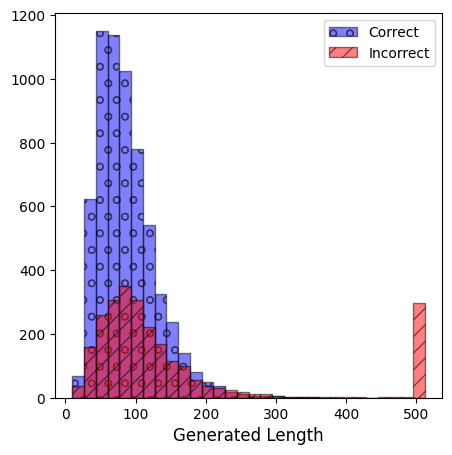

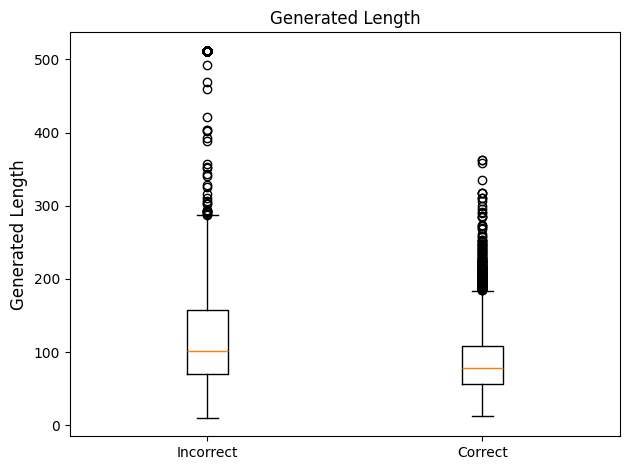

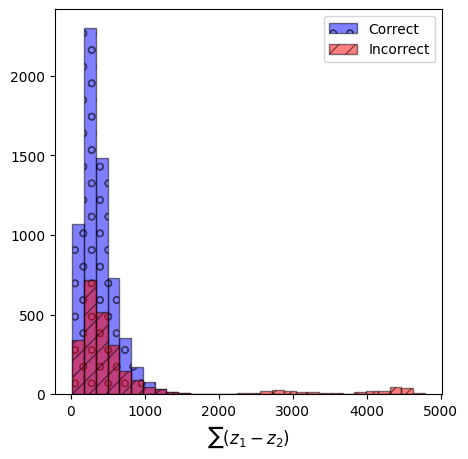

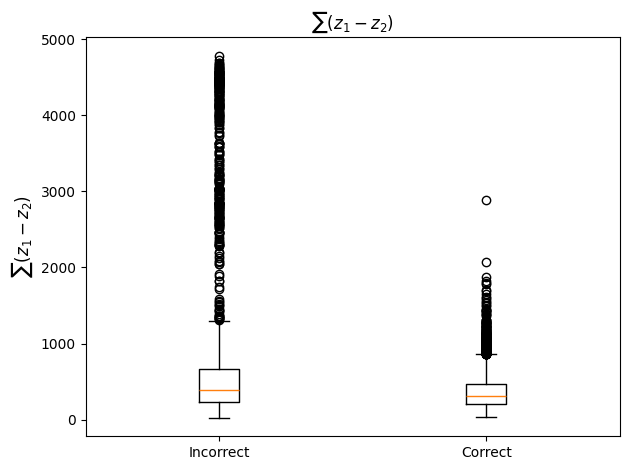

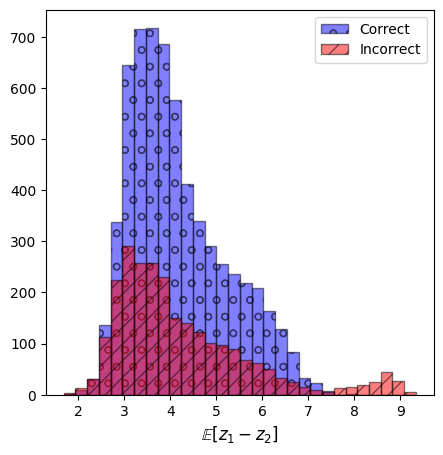

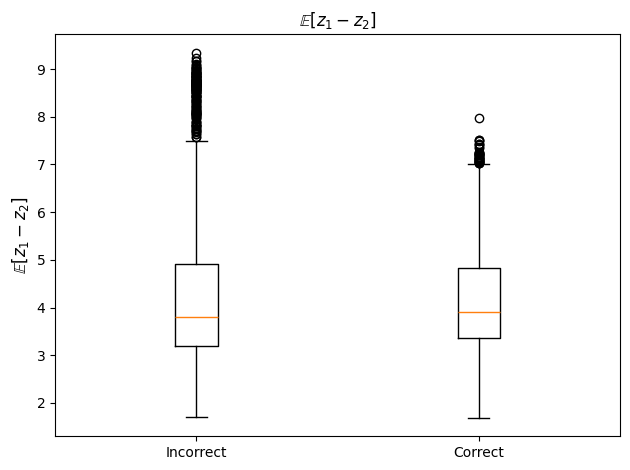

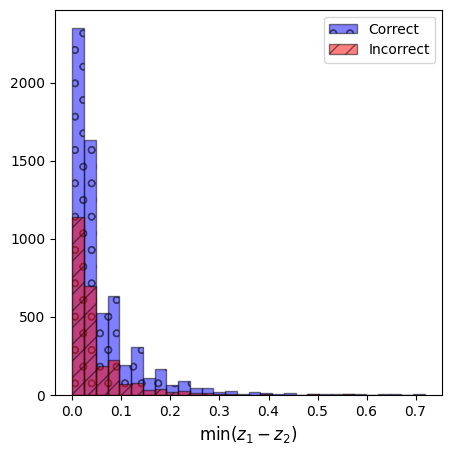

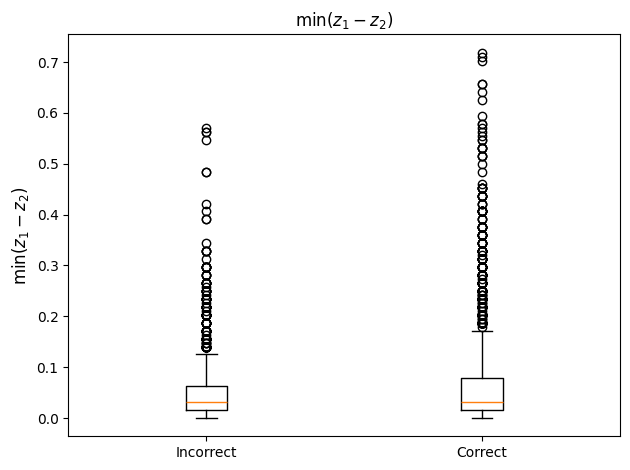

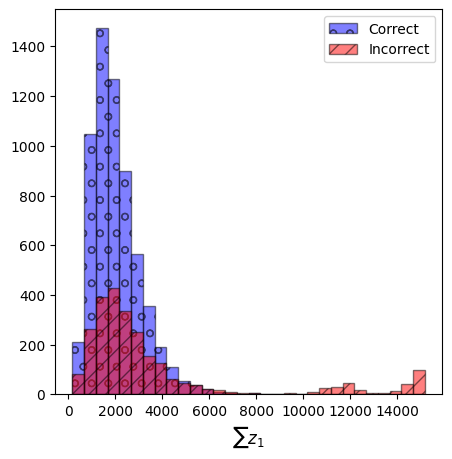

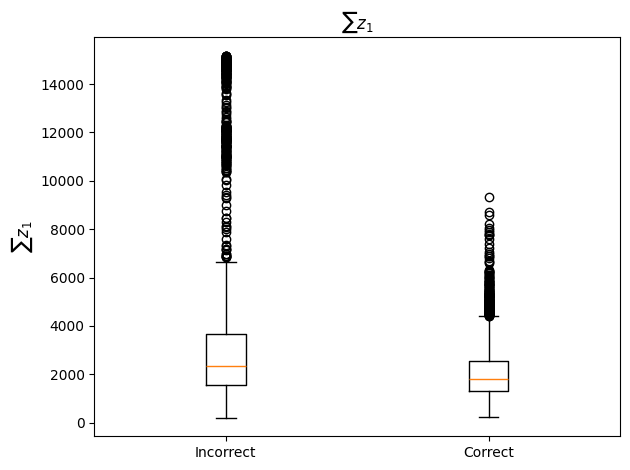

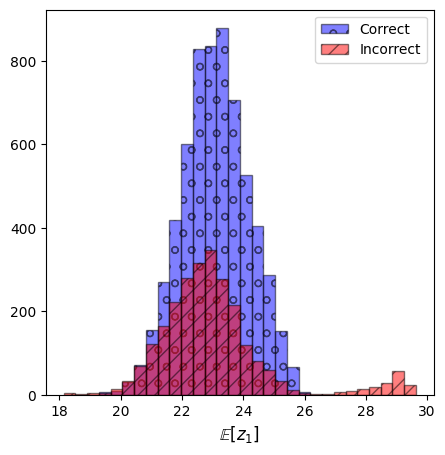

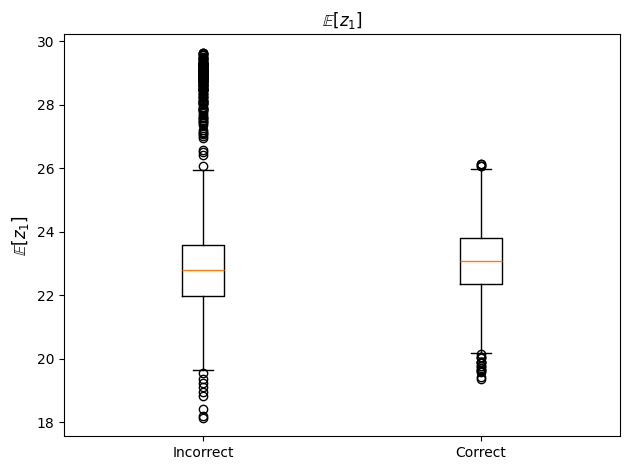

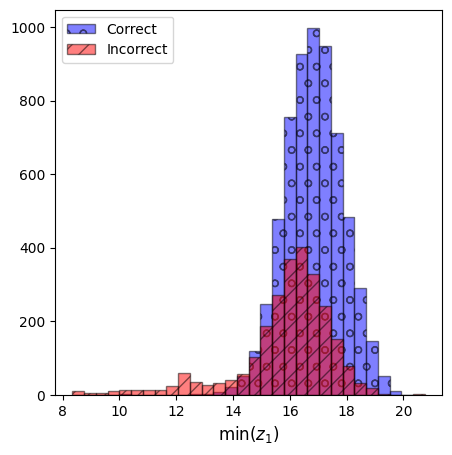

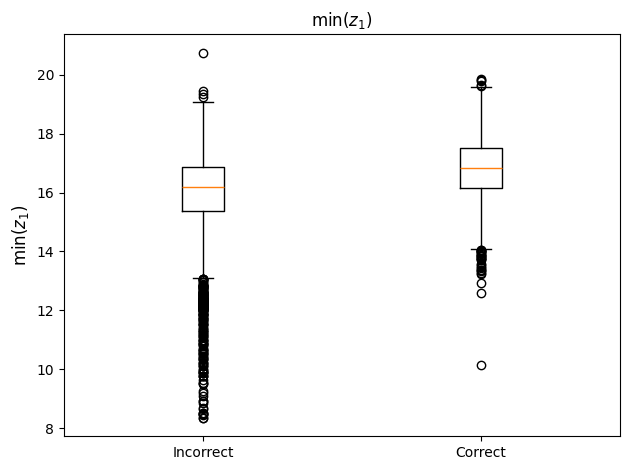

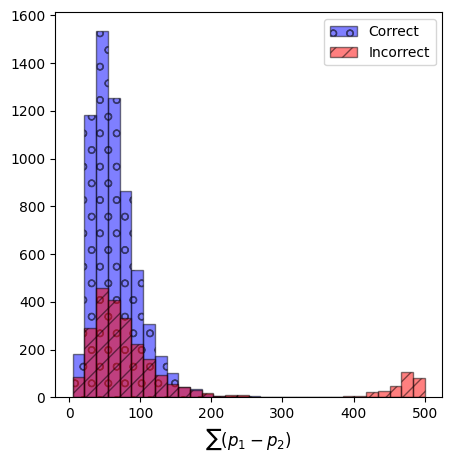

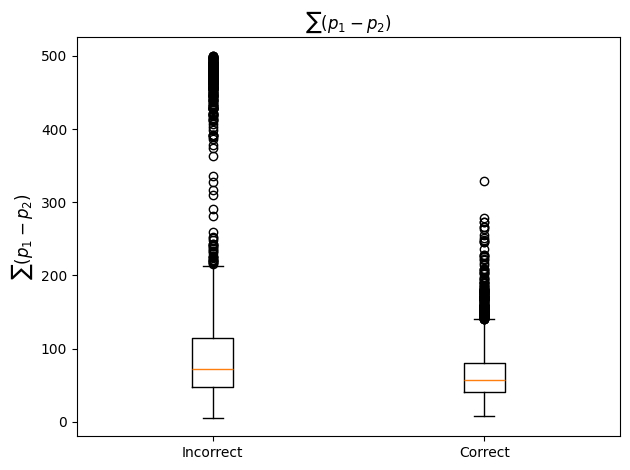

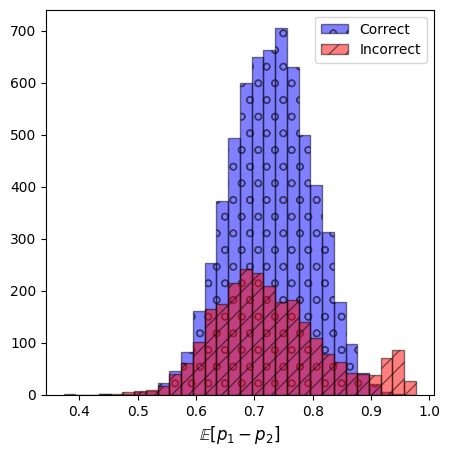

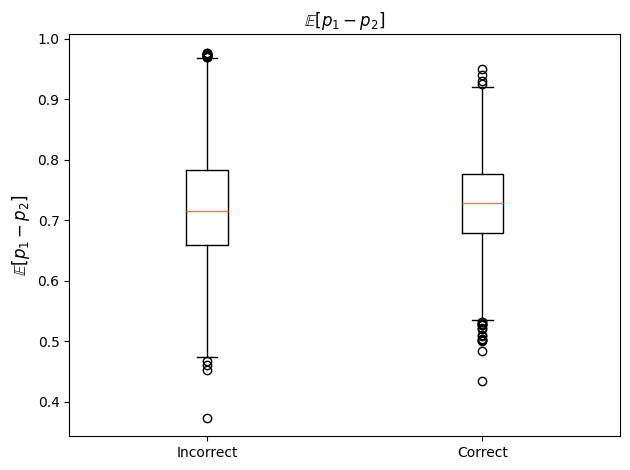

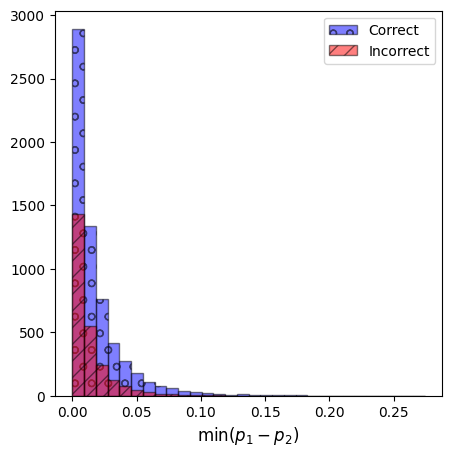

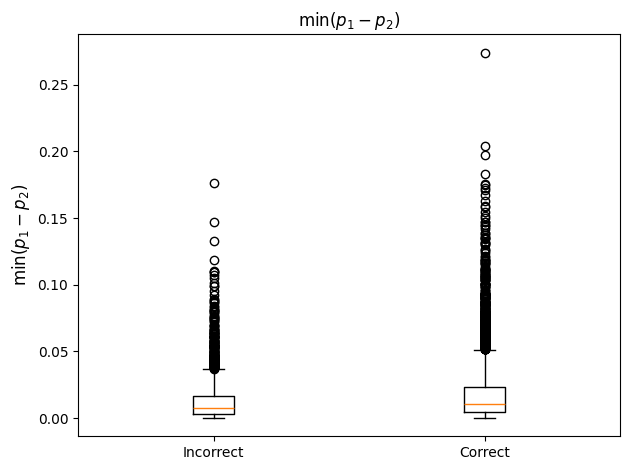

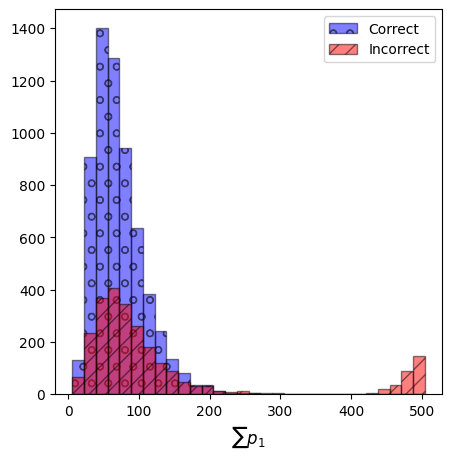

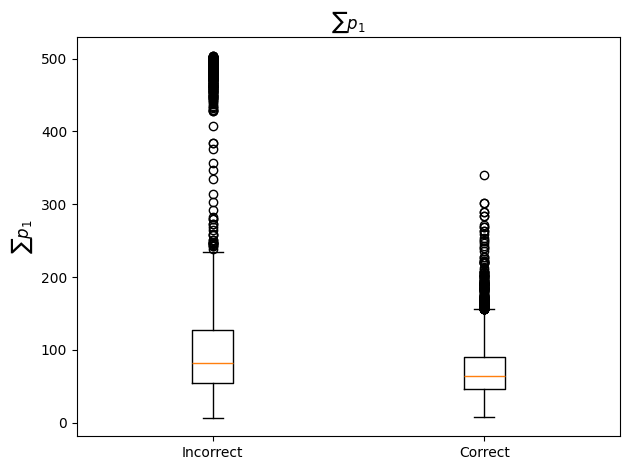

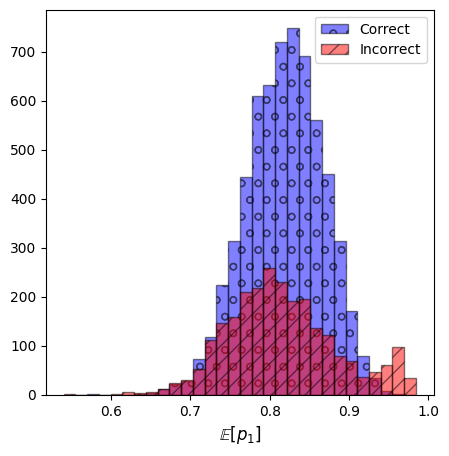

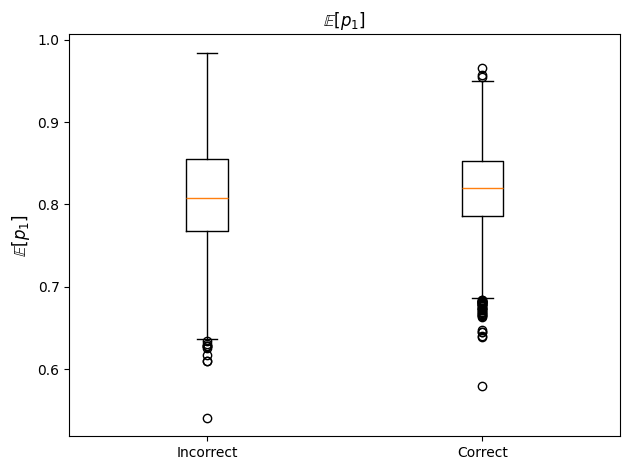

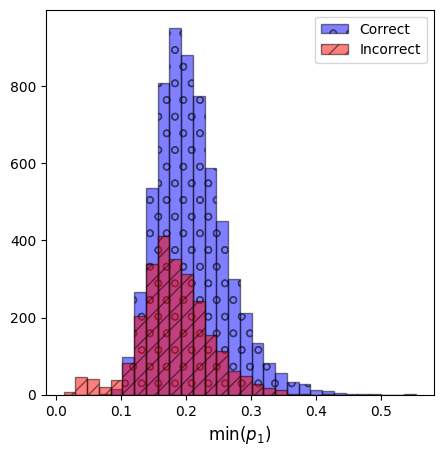

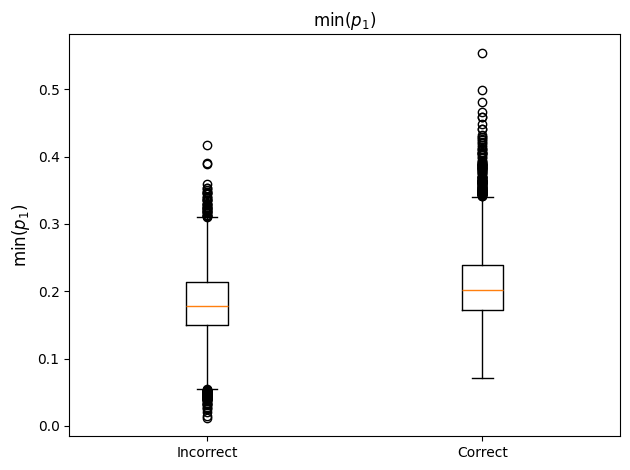

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# LaTeX-friendly feature names
feature_latex_names = {
    'generated_length': r'Generated Length',
    'sum_logits_top1_top2_diff': r'$\sum (z_1 - z_2)$',
    'avg_logits_top1_top2_diff': r'$\mathbb{E}[z_1 - z_2]$',
    'min_logits_top1_top2_diff': r'$\min(z_1 - z_2)$',
    'sum_logits_top1': r'$\sum z_1$',
    'avg_logits_top1': r'$\mathbb{E}[z_1]$',
    'min_logits_top1': r'$\min(z_1)$',
    'sum_prob_top1_top2_diff': r'$\sum (p_1 - p_2)$',
    'avg_prob_top1_top2_diff': r'$\mathbb{E}[p_1 - p_2]$',
    'min_prob_top1_top2_diff': r'$\min(p_1 - p_2)$',
    'sum_prob_top1': r'$\sum p_1$',
    'avg_prob_top1': r'$\mathbb{E}[p_1]$',
    'min_prob_top1': r'$\min(p_1)$'
}

# Convert dictionary features to matrix and get keys
def extract_features_from_dict(features):
    return np.array([list(sample.values()) for sample in features]), list(features[0].keys())

# Prepare features and keys
train_features_matrix, feature_keys = extract_features_from_dict(train_features)
test_features_matrix, _ = extract_features_from_dict(test_features)

# Combine train and test data for comprehensive visualization
all_features_matrix = np.vstack((train_features_matrix, test_features_matrix))
all_labels = np.concatenate((train_labels, test_labels))

# For each feature, plot histograms and box plots
for i, key in enumerate(feature_keys):
    # Get feature values
    feature_values = all_features_matrix[:, i]
    
    # Separate values by label
    feature_values_correct = feature_values[all_labels == 1]
    feature_values_incorrect = feature_values[all_labels == 0]
    
    # Calculate global range for consistent bins
    global_min = min(feature_values_correct.min(), feature_values_incorrect.min())
    global_max = max(feature_values_correct.max(), feature_values_incorrect.max())
    bin_range = (global_min, global_max)
    
    # Create histograms
    plt.figure(figsize=(5, 5))
    
    # Histogram
    plt.hist(feature_values_correct, bins=30, range=bin_range, alpha=0.5, label='Correct', color='blue', edgecolor='black', hatch='o')
    plt.hist(feature_values_incorrect, bins=30, range=bin_range, alpha=0.5, label='Incorrect', color='red', edgecolor='black', hatch='//')
    plt.xlabel(feature_latex_names[key], fontsize=12)
    # plt.ylabel(r'Frequency')
    # plt.title(key)
    plt.legend()
    plt.show()
    
    # Box plot
    data_to_plot = [feature_values_incorrect, feature_values_correct]
    plt.boxplot(data_to_plot, tick_labels=['Incorrect', 'Correct'])
    plt.ylabel(feature_latex_names[key], fontsize=12)
    plt.title(f'{feature_latex_names[key]}')
    
    plt.tight_layout()
    plt.show()

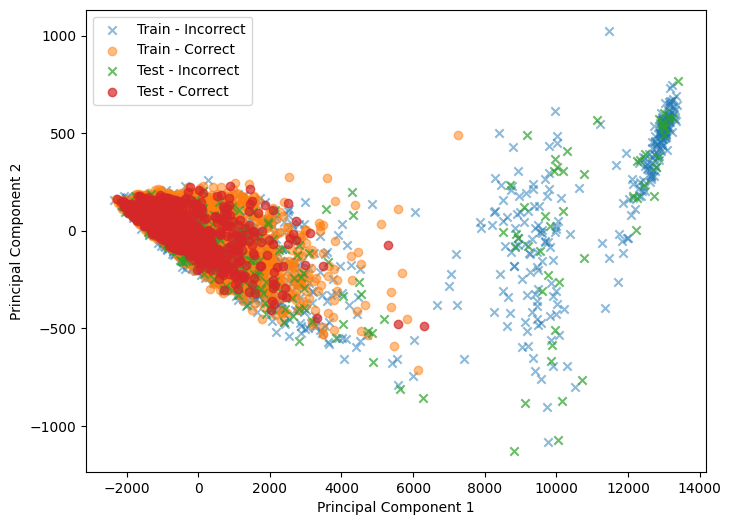

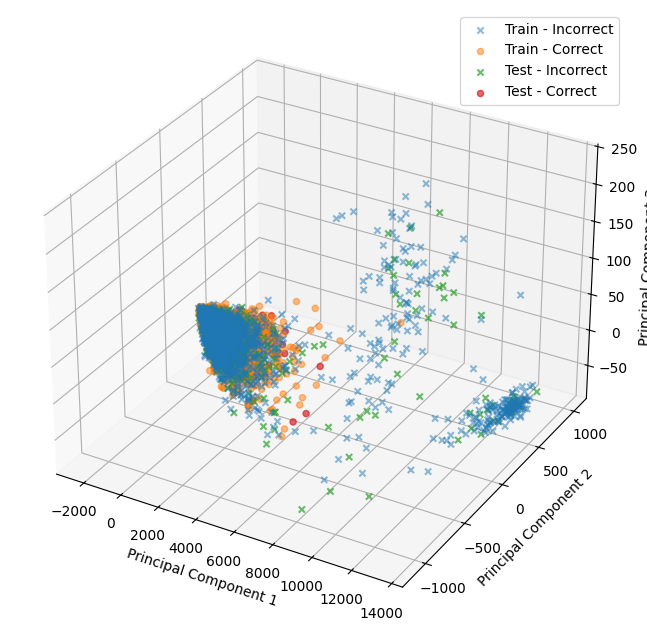

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from mpl_toolkits.mplot3d import Axes3D
import os

# Ensure output directory exists
os.makedirs("outputs/probe-logits-llama-3.2-3B-Instruct-gsm8k-performance_probing", exist_ok=True)

# Example data for train_features and test_features
# Assume train_features and test_features are lists of dictionaries as shown in the question

# Convert dictionary features to matrix
def extract_features_from_dict(features):
    """
    Convert a list of dictionaries into a 2D NumPy array and extract the feature keys.
    
    Args:
        features (list of dict): List of dictionaries representing features.
        
    Returns:
        np.ndarray: 2D array of shape (n_samples, n_features).
        list: List of feature keys (columns of the array).
    """
    keys = list(features[0].keys())
    matrix = np.array([[sample[key] for key in keys] for sample in features])
    return matrix, keys

# Convert data
train_features_matrix, feature_keys = extract_features_from_dict(train_features)
test_features_matrix, _ = extract_features_from_dict(test_features)

# Prepare labels
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# 1. 2D PCA Visualization
pca_2d = PCA(n_components=2)
train_features_2d = pca_2d.fit_transform(train_features_matrix)
test_features_2d = pca_2d.transform(test_features_matrix)

plt.figure(figsize=(8, 6))
plt.scatter(train_features_2d[train_labels == 0][:, 0], train_features_2d[train_labels == 0][:, 1], 
            label="Train - Incorrect", marker='x', alpha=0.5)
plt.scatter(train_features_2d[train_labels == 1][:, 0], train_features_2d[train_labels == 1][:, 1], 
            label="Train - Correct", marker='o', alpha=0.5)
plt.scatter(test_features_2d[test_labels == 0][:, 0], test_features_2d[test_labels == 0][:, 1], 
            label="Test - Incorrect", marker='x', alpha=0.7)
plt.scatter(test_features_2d[test_labels == 1][:, 0], test_features_2d[test_labels == 1][:, 1], 
            label="Test - Correct", marker='o', alpha=0.7)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.savefig("outputs/probe-logits-llama-3.2-3B-Instruct-gsm8k-performance_probing/2d_pca_visualization.pdf")
plt.show()

# 2. 3D PCA Visualization
pca_3d = PCA(n_components=3)
train_features_3d = pca_3d.fit_transform(train_features_matrix)
test_features_3d = pca_3d.transform(test_features_matrix)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(train_features_3d[train_labels == 0][:, 0], train_features_3d[train_labels == 0][:, 1], train_features_3d[train_labels == 0][:, 2], 
           label="Train - Incorrect", marker='x', alpha=0.5)
ax.scatter(train_features_3d[train_labels == 1][:, 0], train_features_3d[train_labels == 1][:, 1], train_features_3d[train_labels == 1][:, 2], 
           label="Train - Correct", marker='o', alpha=0.5)
ax.scatter(test_features_3d[test_labels == 0][:, 0], test_features_3d[test_labels == 0][:, 1], test_features_3d[test_labels == 0][:, 2], 
           label="Test - Incorrect", marker='x', alpha=0.7)
ax.scatter(test_features_3d[test_labels == 1][:, 0], test_features_3d[test_labels == 1][:, 1], test_features_3d[test_labels == 1][:, 2], 
           label="Test - Correct", marker='o', alpha=0.7)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.legend()
plt.savefig("outputs/probe-logits-llama-3.2-3B-Instruct-gsm8k-performance_probing/3d_pca_visualization.pdf")
plt.show()

Logistic Regression Accuracy: 72.18%
Logistic Regression F1 Score: 0.6849


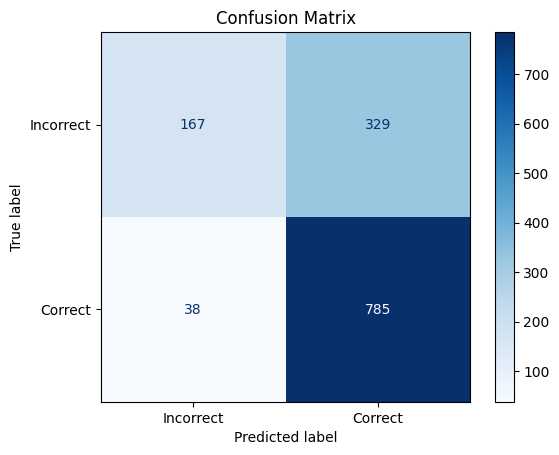

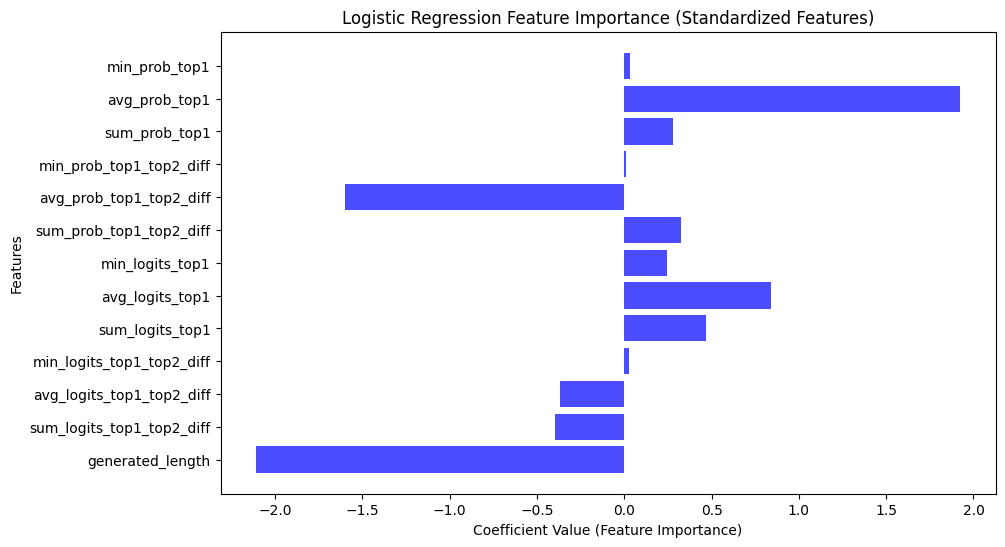


Top 10 Most Important Features (Standardized):
generated_length: -2.1113
avg_prob_top1: 1.9245
avg_prob_top1_top2_diff: -1.5993
avg_logits_top1: 0.8389
sum_logits_top1: 0.4693
sum_logits_top1_top2_diff: -0.3988
avg_logits_top1_top2_diff: -0.3678
sum_prob_top1_top2_diff: 0.3220
sum_prob_top1: 0.2814
min_logits_top1: 0.2450


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Convert dictionary features to matrix
def extract_features_from_dict(features):
    keys = list(features[0].keys())
    matrix = np.array([[sample[key] for key in keys] for sample in features])
    return matrix, keys

# Convert data
train_features_matrix, feature_keys = extract_features_from_dict(train_features)
test_features_matrix, _ = extract_features_from_dict(test_features)

# Scale the data
scaler = StandardScaler()
train_features_matrix = scaler.fit_transform(train_features_matrix)
test_features_matrix = scaler.transform(test_features_matrix)

# Logistic Regression
clf = LogisticRegression(max_iter=5000)
clf.fit(train_features_matrix, train_labels)

# Evaluate
test_predictions = clf.predict(test_features_matrix)
clf_accuracy = np.mean(test_predictions == test_labels)
clf_f1 = f1_score(test_labels, test_predictions, average='weighted')

print(f"Logistic Regression Accuracy: {clf_accuracy * 100:.2f}%")
print(f"Logistic Regression F1 Score: {clf_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Incorrect", "Correct"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("outputs/probe-logits-llama-3.2-3B-Instruct-gsm8k-performance_probing/confusion_matrix_with_scaling.pdf")
plt.show()

# Feature Importance
coefficients = clf.coef_[0]  # Coefficients for the first class
plt.figure(figsize=(10, 6))
plt.barh(feature_keys, coefficients, color='b', alpha=0.7)
plt.xlabel("Coefficient Value (Feature Importance)")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance (Standardized Features)")
plt.savefig("outputs/probe-logits-llama-3.2-3B-Instruct-gsm8k-performance_probing/feature_importance_standardized.pdf")
plt.show()

# Sort features by absolute importance
sorted_features = sorted(zip(feature_keys, coefficients), key=lambda x: abs(x[1]), reverse=True)
print("\nTop 10 Most Important Features (Standardized):")
for feature, coeff in sorted_features[:10]:
    print(f"{feature}: {coeff:.4f}")
